# Exploring latent space

THought: the output image is blurry because when a photo gets compressed it usually gets rid of high wave forms and condenses to averages

In [1]:
import matplotlib.pyplot as plt
import keras
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import glob as gb
import cv2
from sklearn.metrics import mean_squared_error
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# paths
base_train_path = os.path.join("intel_image", "seg_train", "seg_train")
train_building_path = os.path.join(base_train_path, "buildings")
train_forest_path = os.path.join(base_train_path, "forest")
train_glacier_path = os.path.join(base_train_path, "glacier")
train_mountain_path = os.path.join(base_train_path, "mountain")
train_sea_path = os.path.join(base_train_path, "sea")
train_street_path  = os.path.join(base_train_path, "street")
base_test_path = os.path.join("intel_image", "seg_test", "seg_test")
base_pred_path = os.path.join("intel_image", "seg_pred", "seg_pred")


## Helper function to make figures look pretty
def make_pretty(ax, title='', x_label='', y_label='', img=False):
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if img:
        ax.axis('off')
        
    return ax


def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

def plot_image(image):
    plt.imshow(image, cmap="binary")
    
    plt.axis("off")

def show_reconstructions(model, images=None, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    errors = []
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        err = mean_squared_error(reconstructions[image_index].reshape(-1,1), images[image_index].reshape(-1,1))
        errors.append(err)
    return errors

        

# show_reconstructions(ae, images=None, n_images=10)


In [2]:
custom_objects_1 = {'rounded_accuracy': rounded_accuracy}

ae_with_data_aug = keras.models.load_model(os.path.join('models', 'model10312022_with_data_aug2.h5'), custom_objects=custom_objects_1)
regular_ae = keras.models.load_model(os.path.join('models', 'model10312022_no_data_aug1.h5'), custom_objects=custom_objects_1)
regular_ae.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 1024)              2093888   
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 3)       1587011   
                                                                 
Total params: 3,680,899
Trainable params: 3,680,899
Non-trainable params: 0
_________________________________________________________________


In [3]:
regular_ae.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 1024)              2093888   
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 3)       1587011   
                                                                 
Total params: 3,680,899
Trainable params: 3,680,899
Non-trainable params: 0
_________________________________________________________________


In [4]:
decoder = regular_ae.layers[1]

In [5]:
decoder.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 16, 16, 4)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 512)       18944     
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 512)      0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 256)       1179904   
                                                                 
 up_sampling2d_1 (UpSampling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)      

In [6]:
encoder = regular_ae.layers[0]
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)     

In [7]:
X_train = []
y_train = []

############################################
# Original size is 150, 150, 3
resample_x = 128
resample_y = 128
resample_z = 3
############################################
counter = 0
for folder in os.listdir(base_train_path):
    print(str(base_train_path + '/' + folder + '/*.jpg'))
    files = gb.glob(pathname=str(base_train_path +'/'+ folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ###########################################
        # interpolation could be changed too, just arbitrary right now
        image = cv2.resize(image,(resample_x,resample_y), interpolation=cv2.INTER_AREA)
        ###########################################
        X_train.append(image)
        y_train.append(counter)
    counter += 1
    



intel_image\seg_train\seg_train/buildings/*.jpg
intel_image\seg_train\seg_train/forest/*.jpg
intel_image\seg_train\seg_train/glacier/*.jpg
intel_image\seg_train\seg_train/mountain/*.jpg
intel_image\seg_train\seg_train/sea/*.jpg
intel_image\seg_train\seg_train/street/*.jpg


In [8]:
# For shuffling data set
X_train_full = np.asarray(X_train) / 255 # not sure if scaling is needed here
y_train_full = np.array(y_train)
indices = tf.range(start=0, limit=tf.shape(X_train_full)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
shuffled_X_train = tf.gather(X_train_full, shuffled_indices)
shuffled_y_train = tf.gather(y_train_full, shuffled_indices)

X_train, X_valid = shuffled_X_train[:-1000], shuffled_X_train[-1000:]
y_train, y_valid = shuffled_y_train[:-1000], shuffled_y_train[-1000:]

print(f'X_train shape: {X_train.shape}')
print(f'X_train first sample shape: {X_train[0].shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')

X_train shape: (13034, 128, 128, 3)
X_train first sample shape: (128, 128, 3)
y_train shape: (13034,)
y_valid shape: (1000,)


### Taking average of two pictures

1/1 [==============================] - 0s 165ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


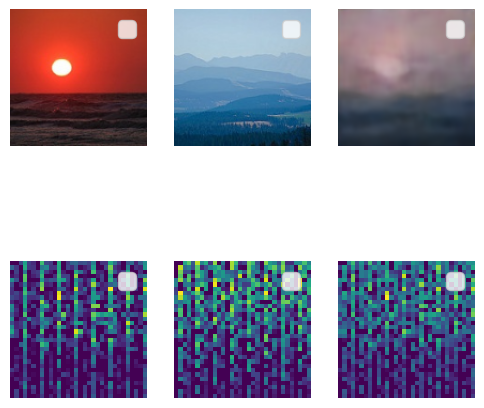

In [9]:

def averager(idx1, idx2):
    
    fig, ax = plt.subplots(figsize=(6, 6), ncols=3, nrows=2)
    ax[0,0].imshow(X_train[idx1])
    ax[0,1].imshow(X_train[idx2])
    sample_1 = X_train[idx1]
    sample_2 = X_train[idx2]
    sample_1 = sample_1.reshape(1, 128, 128, 3)
    sample_2 = sample_2.reshape(1, 128, 128, 3)
    pred_sample_1 = encoder.predict(sample_1)
    pred_sample_2 = encoder.predict(sample_2)
    predictions = [sum(x) / 2 for x in zip(pred_sample_1,pred_sample_2)]   
    predictions = np.array(predictions)
    decoded = decoder.predict(predictions)
    ax[0,2].imshow(decoded[0])
    ax[1,0].imshow(pred_sample_1.reshape(32, 32), interpolation='nearest')
    ax[1,1].imshow(pred_sample_2.reshape(32, 32), interpolation='nearest')
    ax[1,2].imshow(predictions.reshape(32, 32), interpolation='nearest')
    make_pretty(ax[0,2], img=True)
    make_pretty(ax[0,1], img=True)
    make_pretty(ax[0,0], img=True)
    make_pretty(ax[1,0], img=True)
    make_pretty(ax[1,1], img=True)
    make_pretty(ax[1,2], img=True)
    
def averager_given_images(img1, img2):
    fig, ax = plt.subplots(figsize=(6, 6), ncols=3, nrows=2)
    ax[0,0].imshow(img1)
    ax[0,1].imshow(img2)
    sample_1 = img1
    sample_2 = img2
    sample_1 = sample_1.reshape(1, 128, 128, 3)
    sample_2 = sample_2.reshape(1, 128, 128, 3)
    pred_sample_1 = encoder.predict(sample_1)
    pred_sample_2 = encoder.predict(sample_2)
    predictions = [sum(x) / 2 for x in zip(pred_sample_1,pred_sample_2)]   
    predictions = np.array(predictions)
    decoded = decoder.predict(predictions)
    ax[0,2].imshow(decoded[0])
    ax[1,0].imshow(pred_sample_1.reshape(32, 32), interpolation='nearest')
    ax[1,1].imshow(pred_sample_2.reshape(32, 32), interpolation='nearest')
    ax[1,2].imshow(predictions.reshape(32, 32), interpolation='nearest')
    make_pretty(ax[0,2], img=True)
    make_pretty(ax[0,1], img=True)
    make_pretty(ax[0,0], img=True)
    make_pretty(ax[1,0], img=True)
    make_pretty(ax[1,1], img=True)
    make_pretty(ax[1,2], img=True)
 
# 3670, 3920
path_3670 = os.path.join(base_train_path, 'sea', '1175.jpg')
path_3920 = os.path.join(base_train_path, 'forest', '1705.jpg')


image_1 = cv2.imread(path_3670)
image_2 = cv2.imread(path_3920)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_1 = cv2.resize(image_1, (resample_x, resample_y), interpolation=cv2.INTER_AREA)   

image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_2 = cv2.resize(image_2, (resample_x, resample_y), interpolation=cv2.INTER_AREA)

image_1 = image_1 / 255
image_2 = image_2 / 255
averager_given_images(image_1, image_2)
        

In [10]:
#49152



1/1 [==============================] - 0s 335ms/step
[0.007318800771635869, 0.017047472248370877, 0.012132884016211029, 0.015351735385258117, 0.01629160654511319]


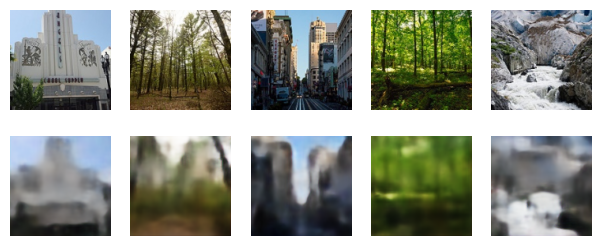

In [11]:
errors = show_reconstructions(regular_ae, X_train[5:], 5)
print(errors)

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



X_train_compressed = encoder.predict(X_valid[:500])
X_train_compressed.shape
prepped_x = X_train_compressed.reshape(500, 1024)
prepped_x.shape
pca = PCA(n_components=12)

tsne = TSNE(n_components=3)
X_pca = pca.fit_transform(prepped_x)
X_pca = ((X_pca - X_pca.min()) / (X_pca.max() - X_pca.min()))
X_valid_2D = tsne.fit_transform(prepped_x)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())



16/16 [==============================] - 2s 107ms/step


c:\CS3400_IPYNB\final_project\final_project_cs3400\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\CS3400_IPYNB\final_project\final_project_cs3400\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


MovieWriter imagemagick unavailable; using Pillow instead.


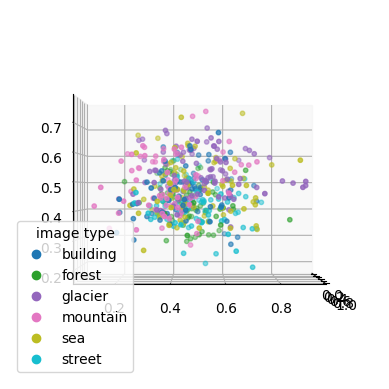

In [13]:
import matplotlib.animation as animation


fig = plt.figure()
ax = plt.axes(projection='3d')
scat = ax.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y_valid[:500], s=10, cmap="tab10", label=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'])
ax.view_init(5, 300)

ax.legend(handles=scat.legend_elements()[0], 
           labels=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'],
           title="image type",
           loc='best')

def rotate(angle):
    ax.view_init(angle / 4, angle)
    
    
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')


In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X_train_compressed = encoder.predict(X_train)
X_train_compressed.shape
prepped_x = X_train_compressed.reshape(13034, 1024)
prepped_x.shape
pca = PCA(n_components=12)

# tsne = TSNE(n_components=3)
X_pca = pca.fit_transform(prepped_x)
X_pca = ((X_pca - X_pca.min()) / (X_pca.max() - X_pca.min()))
# X_valid_2D = tsne.fit_transform(prepped_x)
# X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())



408/408 [==============================] - 92s 226ms/step


In [15]:

rfc = RandomForestClassifier(n_estimators=500, max_depth=9)
knn = KNeighborsClassifier(n_neighbors=9)

# knn.fit(X_pca, y_train)
rfc.fit(X_pca, y_train)
# pred = knn.predict(X_pca)
pred = rfc.predict(X_pca)
accuracy_score(pred, y_train)

0.7071505293846863

In [16]:
X_valid_compressed = encoder.predict(X_valid)
X_valid_compressed.shape
prepped_val_x = X_valid_compressed.reshape(1000, 1024)
prepped_val_x.shape
X_val_pca = pca.fit_transform(prepped_val_x)
X_val_pca = (X_val_pca - X_val_pca.min()) / (X_val_pca.max() - X_val_pca.min())

# pred_val = knn.predict(X_val_pca)
pred_val = rfc.predict(X_val_pca)
accuracy_score(pred_val, y_valid)


32/32 [==============================] - 10s 306ms/step


0.502

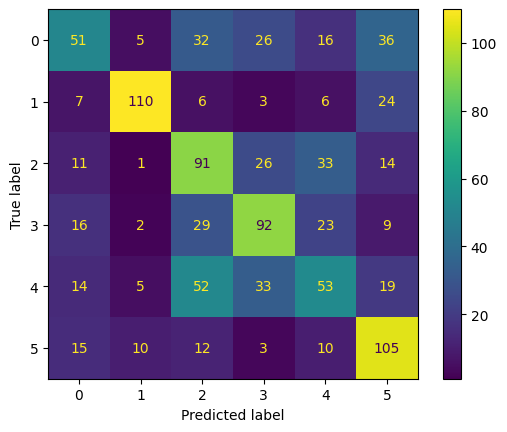

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


conf_mat = confusion_matrix(y_valid, pred_val)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

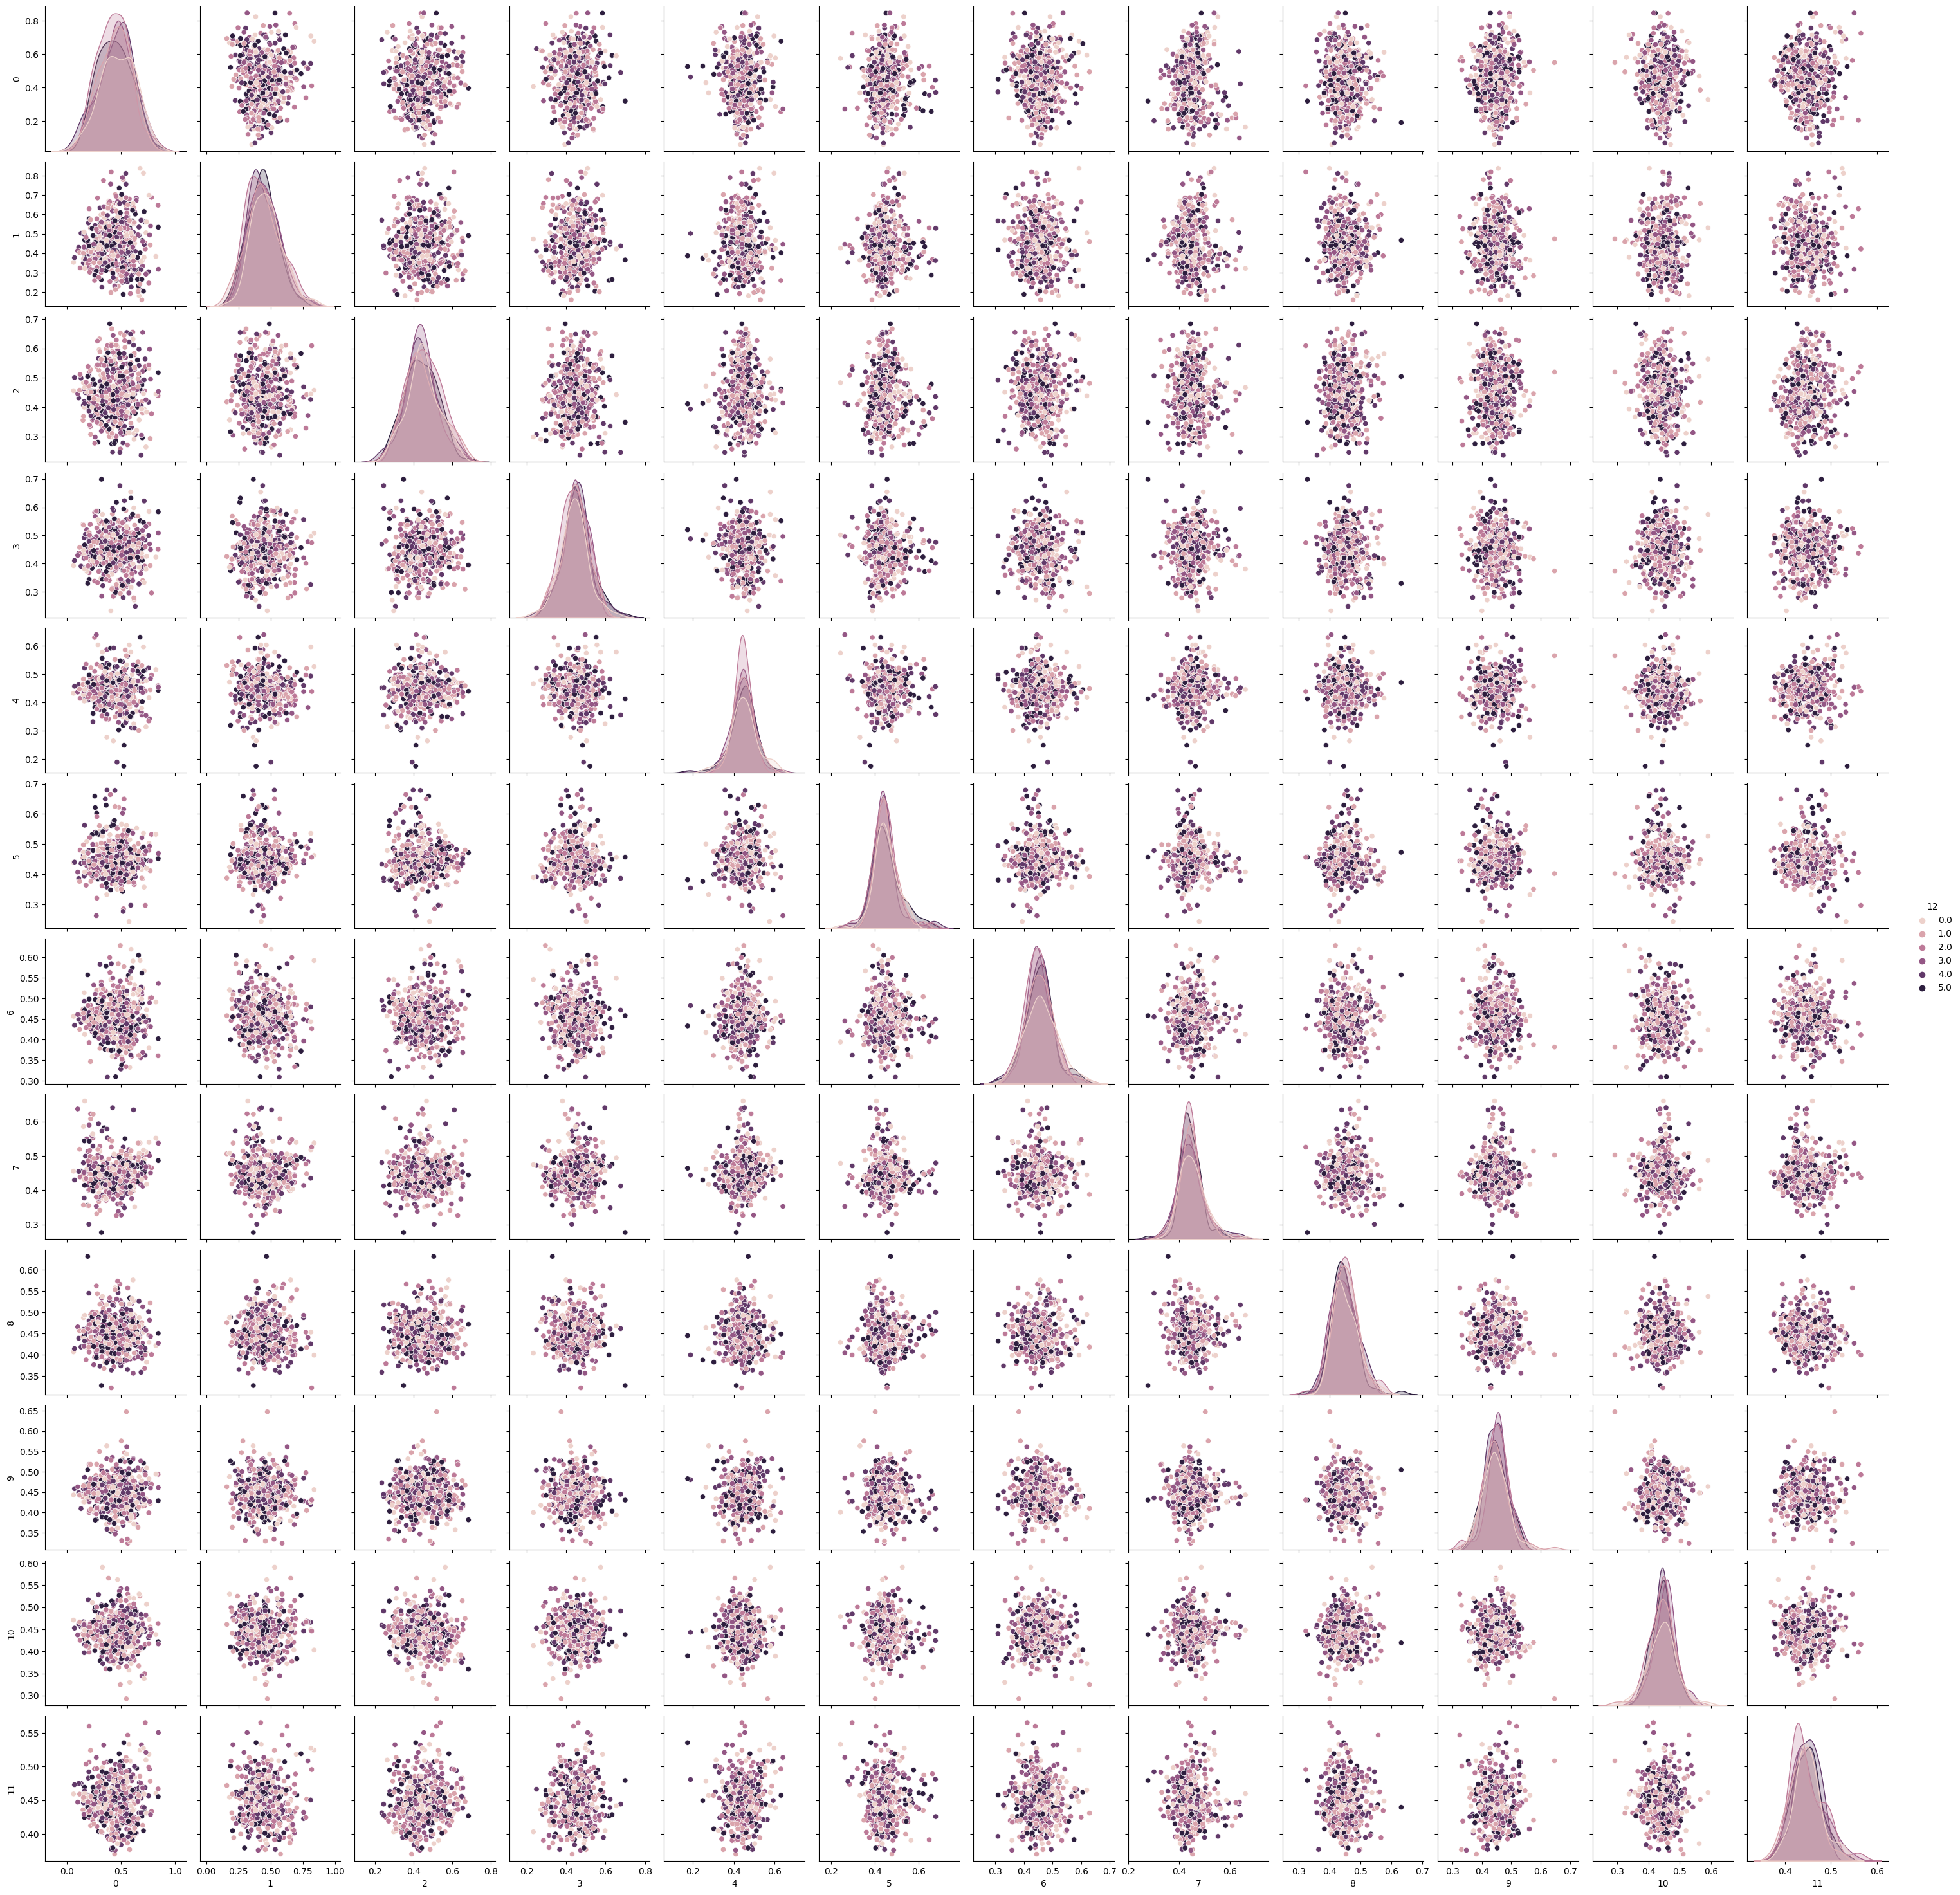

In [18]:
import seaborn as sns
df = pd.DataFrame(X_pca)
df['12'] = pd.Series(y_valid[:500])
df.head()
sns.pairplot(df, kind = 'scatter', hue='12')

In [19]:
#input, latent, output
sample_1 = X_train[514]
sample_2 = X_train[559]


sample_1 = sample_1.reshape(1, 128, 128, 3)
sample_2 = sample_2.reshape(1, 128, 128, 3)
pred_sample_1 = encoder.predict(sample_1)
pred_sample_2 = encoder.predict(sample_2)
output_1 = decoder.predict(pred_sample_1)
output_2 = decoder.predict(pred_sample_2)



1/1 [==============================] - 0s 226ms/step


In [20]:
# Mean squared error 
from sklearn.metrics import mean_squared_error

err_2 = mean_squared_error(sample_2.reshape(-1, 1), output_2.reshape(-1,1))
err_1 = mean_squared_error(sample_1.reshape(-1, 1), output_1.reshape(-1,1))

print(err_1)
print(err_2)

0.0012463940124667946
0.004631130936063438


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: title={'center': 'Output'}>

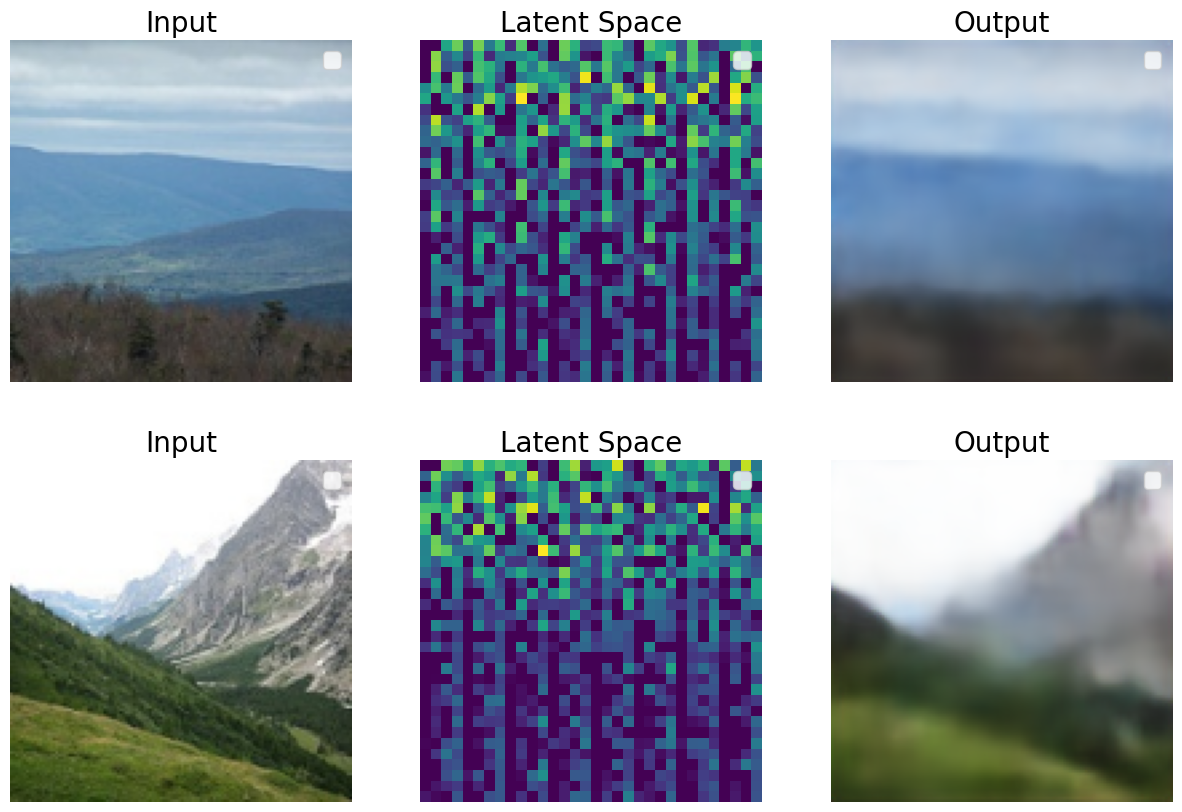

In [21]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)
ax[0,0].imshow(sample_1.reshape(128,128,3))
ax[0,1].imshow(pred_sample_1.reshape(32, 32), interpolation='nearest')
ax[0,2].imshow(output_1.reshape(128, 128,3))

ax[1,0].imshow(sample_2.reshape(128,128,3))
ax[1,1].imshow(pred_sample_2.reshape(32, 32), interpolation='nearest')
ax[1,2].imshow(output_2.reshape(128, 128,3))

make_pretty(ax[0,0], 'Input', img=True)
make_pretty(ax[1,0], 'Input', img=True)
make_pretty(ax[0,1], 'Latent Space', img=True)
make_pretty(ax[1,1], 'Latent Space', img=True)
make_pretty(ax[0,2], 'Output', img=True)
make_pretty(ax[1,2], 'Output', img=True)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: >

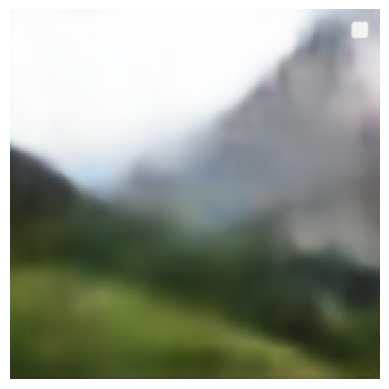

In [22]:
fig, ax = plt.subplots()
ax.imshow(output_2.reshape(128, 128,3))
make_pretty(ax, img=True)

In [23]:
fooo1 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
fooo2 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
fooo3 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
fooo4

NameError: name 'fooo4' is not defined